In [ ]:
# Copyright 2023, Acadential, All rights reserved.

# 12-6. Initialization

이번 시간에는 CIFAR 10 데이터셋에 대해서 학습하는 부분이 포함되어 있는데, CIFAR 10 데이터셋에 학습시키려면 CPU상에서는 시간이 오래 소요되므로 GPU를 사용하는 것을 권장합니다. \
GPU를 사용해서 실습을 진행하기 위해서 저희는 Google Colab에서 실행해보도록 하겠습니다.

저희는 Initialization 방법으로 다음과 같은 방법들을 살펴보았습니다:

1. Random Initialization \
    a. Xavier Initialization: Sigmoid, Tanh 활성화 함수에 대해서 사용됩니다. \
    b. Kaiming (He) Initialization:  ReLU 활성화 함수에 대해서 사용됩니다.


2. Initialization by Transfer Learning \
    즉, 전이 학습을 통한 Initialization



# Google Drive을 Colab에 Mount하기

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
os.chdir("/content/drive/MyDrive/Lesson/인프런 강의 - 딥러닝 이론 실무 완전 정복/practicals/section_12/")

# Random Initialization

## Xavier Initialization

Sigmoid, Tanh 활성화 함수를 사용할 때 적합한 초기화 방법입니다.

In [3]:
import torch
from torch import nn

layer = nn.Linear(32, 16)
_ = torch.nn.init.xavier_normal_(layer.weight)  # inplace operation

## Kaiming (He) Initialization

ReLU 활성화 함수를 사용할 때 적합한 초기화 방법입니다.

In [4]:
layer = nn.Linear(32, 16)
_ = torch.nn.init.kaiming_normal_(layer.weight)  # inplace operation

## 기타 Random Initialization

In [5]:
layer = nn.Linear(32, 16)

# Uniform
_ = torch.nn.init.uniform_(layer.weight, a=-1.0, b=1.0)

# Normal
_ = torch.nn.init.normal_(layer.weight)

# 기존의 Neural Network 구현 코드


기존에 저희가 Section 9에서는 Neural Network 모델을 다음과 같이 구현하였습니다.

In [6]:
import torch
from torch import nn


# 위 방법처럼도 구현할 수 있으나, 더 간단하게 nn.Sequential로 구현할 수 있다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Neural Network을 구성하는 layer들을
        # initialize하는 부분
        self.fc_layers = nn.Sequential(
            nn.Linear(784, 784 // 4),
            nn.ReLU(),
            nn.Linear(784 // 4, 784 // 16),
            nn.ReLU(),
            nn.Linear(784 // 16, 10),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Neural Network의 forward pass을 정의하는 부분
        # x은 input tensor
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x


참고로, nn.Linear에 대한 PyTorch 공식 [Source Code](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)을 보시면 ```reset_parameters```이라는 method가 있고 ```__init__``` 함수 안에서 수행되는 것을 확인할 수 있습니다. 그리고 ```reset_parameters``` method은 weight을 nn.init.kaiming_uniform_로 초기화하는 것을 확인할 수 있습니다.

즉, PyTorch에서는 기본적으로 nn.Linear의 weight을 Kaiming Initialization으로 초기화해줍니다.

In [7]:
model = NeuralNetwork()

In [8]:
# Initialize된 모델의 parameter을 살펴봅시다.
next(iter(model.parameters()))

Parameter containing:
tensor([[ 0.0043, -0.0294,  0.0336,  ..., -0.0339, -0.0009,  0.0069],
        [ 0.0268, -0.0355,  0.0054,  ...,  0.0317,  0.0268,  0.0111],
        [-0.0332, -0.0341,  0.0351,  ...,  0.0174, -0.0168, -0.0054],
        ...,
        [ 0.0229, -0.0306,  0.0323,  ...,  0.0257, -0.0298, -0.0044],
        [ 0.0324,  0.0336,  0.0079,  ...,  0.0336, -0.0326,  0.0143],
        [ 0.0208, -0.0352, -0.0345,  ..., -0.0323,  0.0319, -0.0062]],
       requires_grad=True)

보시다시피 별도로 Initialization하지 않아도 대부분 -1 ~ 1 사이의 Random한 값들로 초기화된 것을 확인할 수 있습니다. \
근데 만약에 명시적으로 Initialization을 하고 싶다면 어떻게 해야할까요? \
예를 들어서 각 Layer마다 조금씩 다르게 Initialization을 하고 싶다면 어떻게 해야할까요?

## Initialization 적용해보기

In [9]:
import torch
from torch import nn


# 위 방법처럼도 구현할 수 있으나, 더 간단하게 nn.Sequential로 구현할 수 있습니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Neural Network을 구성하는 layer들을
        # initialize하는 부분
        self.fc_layers = nn.Sequential(
            nn.Linear(784, 784 // 4),  # Kaiming
            nn.ReLU(),
            nn.Linear(784 // 4, 784 // 16),  # Kaiming
            nn.ReLU(),
            nn.Linear(784 // 16, 10),  # Xavier
            nn.Sigmoid(),
        )

        self._init_weights(self.fc_layers[0], mode='kaiming')
        self._init_weights(self.fc_layers[1], mode='kaiming')
        self._init_weights(self.fc_layers[2], mode='xavier')

    def forward(self, x):
        # Neural Network의 forward pass을 정의하는 부분
        # x은 input tensor
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x

    def _init_weights(self, module, mode='xavier'):
        if isinstance(module, nn.Linear):
            if mode == 'xavier':
                torch.nn.init.xavier_normal_(module.weight)
            elif mode == 'kaiming':
                torch.nn.init.kaiming_normal_(module.weight)

            if module.bias is not None:  # Bias에 대한 initialization
                module.bias.data.zero_()


In [10]:
model = NeuralNetwork()

# Initialization by Transfer Learning

Random Initialization에 이어서 Transfer Learning을 통한 initialization도 살펴보도록 하겠습니다. \
Torchvision에서는 다양한 pre-trained model을 제공하고 있습니다. \
예를 들어서 ImageNet에 대해서 Pre-trained된 Image Classification 모델인 VGG, ResNet 등등 다양한 모델들이 있습니다.

1. (Torchvision을 사용해서) Pre-trained된 모델의 weight 가져오기
2. Pre-trained된 모델의 weight 일부분만 가져오기

In [11]:
import torchvision
import os

In [12]:
# ResNet50

from torchvision.models import resnet50, ResNet50_Weights

# Old weights with accuracy 76.130%
resnet50_v1 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# New weights with accuracy 80.858%
resnet50_v2 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
resnet_best = resnet50(weights=ResNet50_Weights.DEFAULT)

# No weights - random initialization
resnet50_random_init = resnet50(weights=None)

위 방법에서 초기화된 ResNet50은 ImageNet1K에서 학습된 가중치를 사용하고 있습니다. \
이 가중치는 ImageNet1K의 1000개의 클래스를 분류하기 위해 학습된 가중치이기 때문에 우리가 사용하는 데이터셋과는 다른 클래스를 분류하기 위한 가중치입니다. \
따라서 이 가중치를 그대로 사용하는 것은 좋은 방법이 아닙니다. \
우리가 사용하는 데이터셋에 맞게 가중치를 초기화하는 방법을 알아보겠습니다.

In [14]:
# 예를 들어서 CIFAR-10 데이터셋을 사용한다고 가정해보겠습니다.
# Random Initialized ResNet50 (for CIFAR10)
resnet50_random_init = resnet50(num_classes=10, weights=None)

# First Randomly Initialized ResNet50
resnet50_pretrained = resnet50(num_classes=10, weights=None)

# Replace weights with the pretrained ones
layers_to_filter_out = []
model_state_dict = resnet50_pretrained.state_dict()

best_model_weight = resnet50_v2.state_dict()

for layer in best_model_weight.keys():
    if model_state_dict[layer].shape != best_model_weight[layer].shape:
        layers_to_filter_out.append(layer)

print("Layers to filter out", layers_to_filter_out)
for layer in layers_to_filter_out:
    del best_model_weight[layer]

resnet50_pretrained.load_state_dict(best_model_weight, strict=False)

Layers to filter out ['fc.weight', 'fc.bias']


_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [15]:
from src.cifar10 import get_dataloaders
from src.train_val import train_loop, val_loop
import matplotlib.pyplot as plt

In [16]:
next(resnet50_random_init.parameters()).device # returns a boolean


device(type='cpu')

In [17]:
_ = resnet50_random_init.to("cuda")

In [18]:
next(resnet50_random_init.parameters()).device # returns a boolean


device(type='cuda', index=0)

In [19]:
train_dataloader, test_dataloader = get_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


In [20]:
loss_fn = nn.CrossEntropyLoss()

In [21]:
# Random Initialized ResNet50
optimizer = torch.optim.SGD(resnet50_random_init.parameters(),
                            lr=0.001)

epochs = 10
train_loss_history = []
test_loss_history = []
test_acc_history = []
epochs = 10
best_acc = 0.

os.makedirs("checkpoints", exist_ok=True)

for epoch in range(epochs):
    print(f"------------------Epoch {epoch} Train------------------")
    train_losses = train_loop(resnet50_random_init, train_dataloader, loss_fn, optimizer)
    train_loss_history.extend(train_losses)
    print(f"------------------Epoch {epoch} Test------------------")
    test_losses, test_acc = val_loop(resnet50_random_init, test_dataloader, loss_fn)
    test_loss_history.append(test_losses)
    test_acc_history.append(test_acc)
    # if test_acc > best_acc:
    #     best_acc = test_acc
    #     torch.save(resnet50_random_init.state_dict(), "checkpoints/best_model.pt")

------------------Epoch 0 Train------------------


Train Loss: 2.3502: 100%|██████████| 782/782 [00:45<00:00, 17.01it/s]


------------------Epoch 0 Test------------------


Test Loss: 2.3478: 100%|██████████| 157/157 [00:05<00:00, 29.77it/s]


------------------Epoch 1 Train------------------


Train Loss: 2.4334: 100%|██████████| 782/782 [00:40<00:00, 19.46it/s]


------------------Epoch 1 Test------------------


Test Loss: 2.1772: 100%|██████████| 157/157 [00:04<00:00, 34.18it/s]


------------------Epoch 2 Train------------------


Train Loss: 2.0342: 100%|██████████| 782/782 [00:39<00:00, 19.59it/s]


------------------Epoch 2 Test------------------


Test Loss: 2.1499: 100%|██████████| 157/157 [00:04<00:00, 35.17it/s]


------------------Epoch 3 Train------------------


Train Loss: 2.4355: 100%|██████████| 782/782 [00:40<00:00, 19.25it/s]


------------------Epoch 3 Test------------------


Test Loss: 1.8185: 100%|██████████| 157/157 [00:04<00:00, 34.37it/s]


------------------Epoch 4 Train------------------


Train Loss: 2.2343: 100%|██████████| 782/782 [00:38<00:00, 20.08it/s]


------------------Epoch 4 Test------------------


Test Loss: 1.7907: 100%|██████████| 157/157 [00:04<00:00, 34.47it/s]


------------------Epoch 5 Train------------------


Train Loss: 1.8534: 100%|██████████| 782/782 [00:39<00:00, 20.05it/s]


------------------Epoch 5 Test------------------


Test Loss: 1.4725: 100%|██████████| 157/157 [00:04<00:00, 35.10it/s]


------------------Epoch 6 Train------------------


Train Loss: 2.0638: 100%|██████████| 782/782 [00:40<00:00, 19.42it/s]


------------------Epoch 6 Test------------------


Test Loss: 1.6136: 100%|██████████| 157/157 [00:04<00:00, 34.61it/s]


------------------Epoch 7 Train------------------


Train Loss: 1.6712: 100%|██████████| 782/782 [00:39<00:00, 20.02it/s]


------------------Epoch 7 Test------------------


Test Loss: 1.6236: 100%|██████████| 157/157 [00:04<00:00, 34.65it/s]


------------------Epoch 8 Train------------------


Train Loss: 1.3688: 100%|██████████| 782/782 [00:39<00:00, 19.88it/s]


------------------Epoch 8 Test------------------


Test Loss: 1.3610: 100%|██████████| 157/157 [00:04<00:00, 34.45it/s]


------------------Epoch 9 Train------------------


Train Loss: 2.4361: 100%|██████████| 782/782 [00:39<00:00, 19.98it/s]


------------------Epoch 9 Test------------------


Test Loss: 1.3875: 100%|██████████| 157/157 [00:04<00:00, 34.88it/s]


In [ ]:
os.makedirs("figures", exist_ok=True)

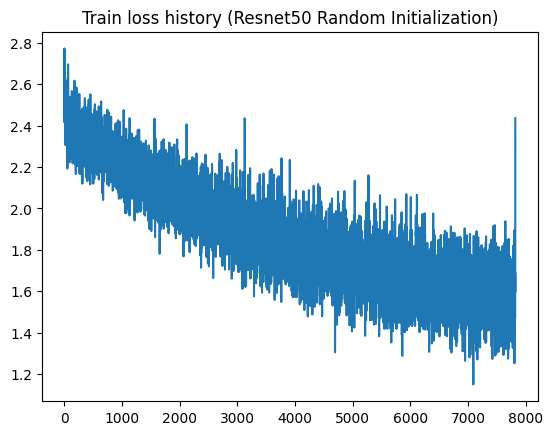

In [22]:
plt.figure()
plt.plot(train_loss_history)
plt.title('Train loss history (Resnet50 Random Initialization)')
plt.savefig("figures/resnet50_random_init_train_loss.png")

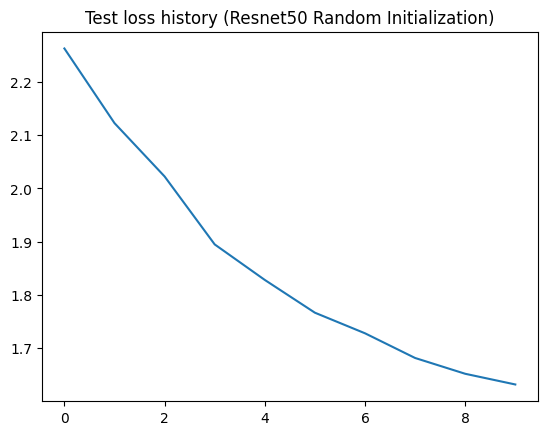

In [23]:
plt.figure()
plt.plot(test_loss_history)
plt.title('Test loss history (Resnet50 Random Initialization)')
plt.savefig("figures/resnet50_random_init_test_loss.png")

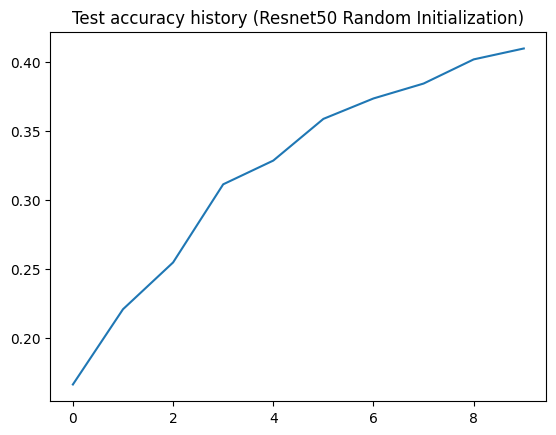

In [24]:
plt.figure()
plt.plot(test_acc_history)
plt.title('Test accuracy history (Resnet50 Random Initialization)')
plt.savefig("figures/resnet50_random_init_test_acc.png")

In [25]:
_ = resnet50_pretrained.to("cuda")

In [26]:
# Resnet50 with pretrained weights
# Random Initialized ResNet50
optimizer = torch.optim.SGD(resnet50_pretrained.parameters(),
                            lr=0.001)

epochs = 10
train_loss_history = []
test_loss_history = []
test_acc_history = []
epochs = 10
best_acc = 0.

os.makedirs("checkpoints", exist_ok=True)

for epoch in range(epochs):
    print(f"------------------Epoch {epoch} Train------------------")
    train_losses = train_loop(resnet50_pretrained, train_dataloader, loss_fn, optimizer)
    train_loss_history.extend(train_losses)
    print(f"------------------Epoch {epoch} Test------------------")
    test_losses, test_acc = val_loop(resnet50_pretrained, test_dataloader, loss_fn)
    test_loss_history.append(test_losses)
    test_acc_history.append(test_acc)
    # if test_acc > best_acc:
    #     best_acc = test_acc
    #     torch.save(resnet50_pretrained.state_dict(), "checkpoints/best_model.pt")

------------------Epoch 0 Train------------------


Train Loss: 2.2153: 100%|██████████| 782/782 [00:40<00:00, 19.40it/s]


------------------Epoch 0 Test------------------


Test Loss: 2.1969: 100%|██████████| 157/157 [00:04<00:00, 31.72it/s]


------------------Epoch 1 Train------------------


Train Loss: 1.7617: 100%|██████████| 782/782 [00:38<00:00, 20.24it/s]


------------------Epoch 1 Test------------------


Test Loss: 2.1371: 100%|██████████| 157/157 [00:05<00:00, 29.21it/s]


------------------Epoch 2 Train------------------


Train Loss: 1.0174: 100%|██████████| 782/782 [00:38<00:00, 20.38it/s]


------------------Epoch 2 Test------------------


Test Loss: 1.9003: 100%|██████████| 157/157 [00:05<00:00, 27.83it/s]


------------------Epoch 3 Train------------------


Train Loss: 1.1904: 100%|██████████| 782/782 [00:38<00:00, 20.38it/s]


------------------Epoch 3 Test------------------


Test Loss: 1.8411: 100%|██████████| 157/157 [00:05<00:00, 26.45it/s]


------------------Epoch 4 Train------------------


Train Loss: 0.8446: 100%|██████████| 782/782 [00:38<00:00, 20.57it/s]


------------------Epoch 4 Test------------------


Test Loss: 1.6967: 100%|██████████| 157/157 [00:06<00:00, 25.66it/s]


------------------Epoch 5 Train------------------


Train Loss: 1.6619: 100%|██████████| 782/782 [00:38<00:00, 20.57it/s]


------------------Epoch 5 Test------------------


Test Loss: 1.8392: 100%|██████████| 157/157 [00:06<00:00, 25.58it/s]


------------------Epoch 6 Train------------------


Train Loss: 1.2285: 100%|██████████| 782/782 [00:39<00:00, 20.01it/s]


------------------Epoch 6 Test------------------


Test Loss: 1.8810: 100%|██████████| 157/157 [00:05<00:00, 28.85it/s]


------------------Epoch 7 Train------------------


Train Loss: 1.3982: 100%|██████████| 782/782 [00:40<00:00, 19.53it/s]


------------------Epoch 7 Test------------------


Test Loss: 1.7884: 100%|██████████| 157/157 [00:05<00:00, 30.49it/s]


------------------Epoch 8 Train------------------


Train Loss: 0.8670: 100%|██████████| 782/782 [00:39<00:00, 19.99it/s]


------------------Epoch 8 Test------------------


Test Loss: 1.6569: 100%|██████████| 157/157 [00:04<00:00, 32.40it/s]


------------------Epoch 9 Train------------------


Train Loss: 0.6362: 100%|██████████| 782/782 [00:39<00:00, 20.00it/s]


------------------Epoch 9 Test------------------


Test Loss: 1.6963: 100%|██████████| 157/157 [00:04<00:00, 34.68it/s]


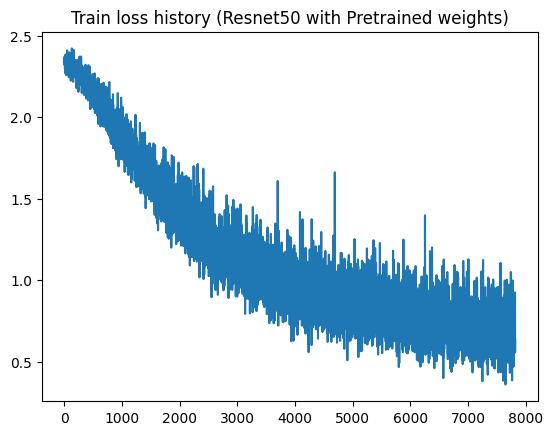

In [27]:
plt.figure()
plt.plot(train_loss_history)
plt.title('Train loss history (Resnet50 with Pretrained weights)')
plt.savefig("figures/resnet50_pretrained_train_loss.png")

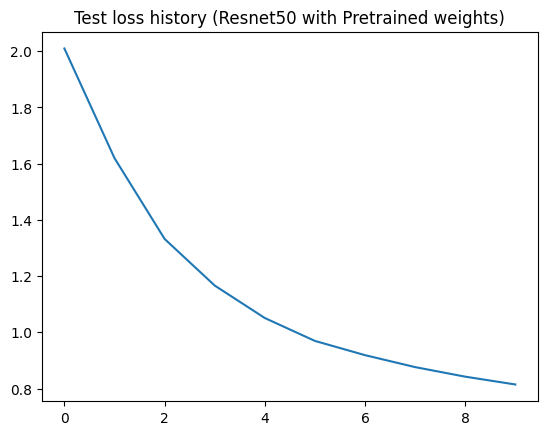

In [28]:
plt.figure()
plt.plot(test_loss_history)
plt.title('Test loss history (Resnet50 with Pretrained weights)')
plt.savefig("figures/resnet50_pretrained_test_loss.png")

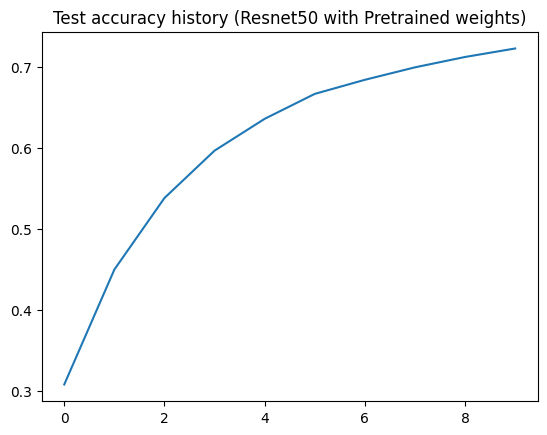

In [29]:
plt.figure()
plt.plot(test_acc_history)
plt.title('Test accuracy history (Resnet50 with Pretrained weights)')
plt.savefig("figures/resnet50_pretrained_test_acc.png")